In [ ]:
# -*- coding: utf-8 -*-
"""DeepLearning_Project.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1YUSqVJ491wEGuiNPGnhaGYkUuCwjySyZ
"""

import torch
import torchvision

"""Initialize the training and testing parameters."""

n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

"""Downloading the MNIST dataset"""

data_dir = '/content/drive/MyDrive/DL_CW3/MNIST_data/'

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(data_dir, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(data_dir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape


torch.Size([1000, 1, 28, 28])

In [ ]:
pip install torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torch

In [ ]:
pip install torchvision

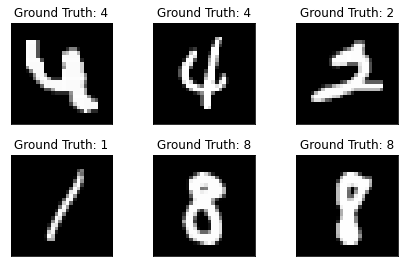

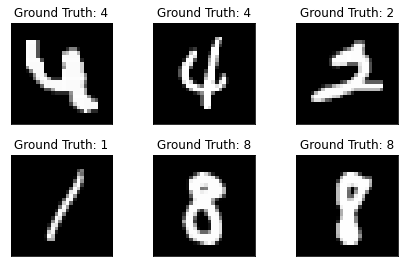

In [ ]:
"""Visualizing some of the ground truth image."""
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig


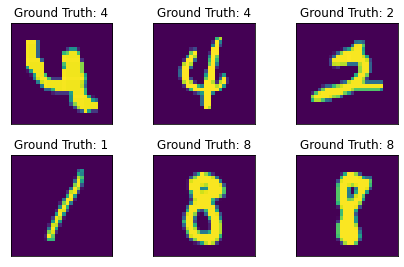

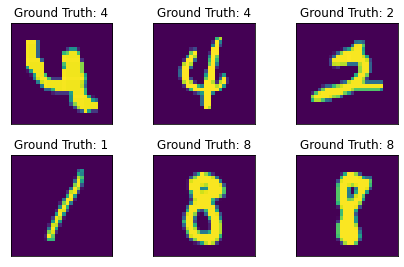

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].cpu(), cmap='viridis', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.460591
Train Epoch: 1 [640/60000 (1%)]	Loss: 3.451201
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.693131
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.131643
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.118490
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.004946
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.953675
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.637011
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.743585
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.489137
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.628783
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.400514
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.605011
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.443046
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.505669
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.361563
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.395736
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.345038
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.267946
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.397766
Train Epoch: 1 [12800/60000 (

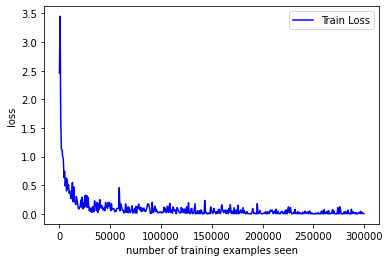

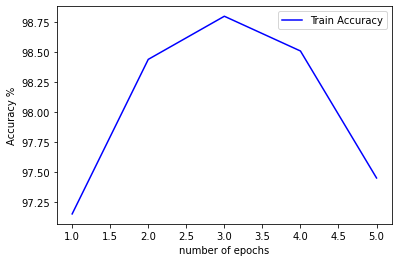

In [ ]:
"""### ResNet50 """
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet50
from torchvision.models import googlenet

"""Initializing model with output for 10 classes and converting model to accept """
n_epochs = 5
model = resnet50(num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model=model.cuda()

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc1 = []

criterion=nn.CrossEntropyLoss()

"""Training model function"""

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data=data.cuda()
    target=target.cuda()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), '/resnetmodel.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

"""Testing model function"""

def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data=data.cuda()
      target=target.cuda()
      output = model(data)
      test_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_acc = 100 * correct / len(test_loader.dataset)
  test_acc1.append(test_acc)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

"""Training and testing results at each epoch"""

epochs=[]
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
  epochs.append(epoch)

"""Ploting loss curve """

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')
fig

"""Plotting accuracy curve"""

fig = plt.figure()
plt.plot(epochs, test_acc1, color='blue')
plt.legend(['Train Accuracy'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy %')
fig

"""Visualizing predictions"""
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  example_data=example_data.cuda()
  output = model(example_data)


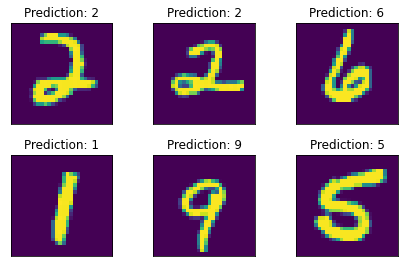

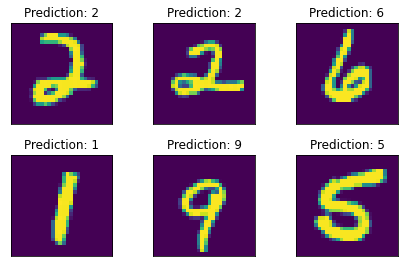

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].cpu(), cmap='viridis', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig


In [ ]:
"""### ResNet101 """
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet101
from torchvision.models import googlenet

"""Initializing model with output for 10 classes and converting model to accept """

model3 = resnet101(num_classes=10)
model3.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model3=model3.cuda()

optimizer = optim.SGD(model3.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses3 = []
train_counter3 = []
test_losses3 = []
test_counter3 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc3 = []

criterion=nn.CrossEntropyLoss()

"""Training model function"""

def train101(epoch):
  model3.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data=data.cuda()
    target=target.cuda()
    output = model3(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses3.append(loss.item())
      train_counter3.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model3.state_dict(), '/resnet101model.pth')
      torch.save(optimizer.state_dict(), '/resnet101_optimizer.pth')

"""Testing model function"""

def test101():
  model3.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data=data.cuda()
      target=target.cuda()
      output = model3(data)
      test_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses3.append(test_loss)
  test_acc = 100 * correct / len(test_loader.dataset)
  test_acc3.append(test_acc)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

"""Training and testing results at each epoch"""

epochs=[]
for epoch in range(1, n_epochs + 1):
  train101(epoch)
  test101()
  epochs.append(epoch)




Train Epoch: 1 [0/60000 (0%)]	Loss: 2.736441
Train Epoch: 1 [640/60000 (1%)]	Loss: 3.321609
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.123578
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.783918
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.835347
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.769532
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.113218
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.800911
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.342980
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.205524
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.082914
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.621557
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.973252
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.765257
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.645011
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.479493
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.668660
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.424783
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.540089
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.520111
Train Epoch: 1 [12800/60000 (

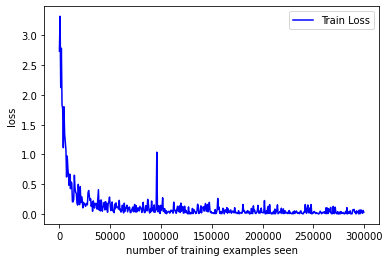

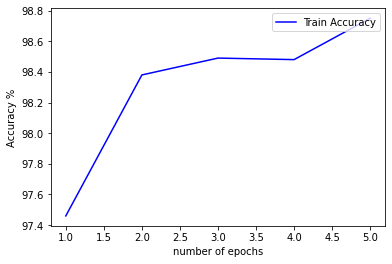

In [ ]:
"""Ploting loss curve """

fig = plt.figure()
plt.plot(train_counter3, train_losses3, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')
fig

"""Plotting accuracy curve"""

fig = plt.figure()
plt.plot(epochs, test_acc3, color='blue')
plt.legend(['Train Accuracy'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy %')
fig

"""Visualizing predictions"""

with torch.no_grad():
  example_data=example_data.cuda()
  output = model3(example_data)


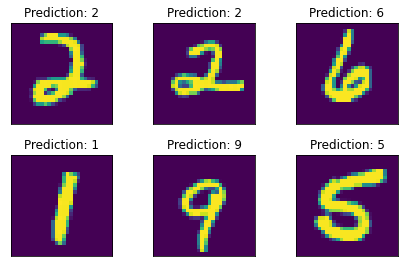

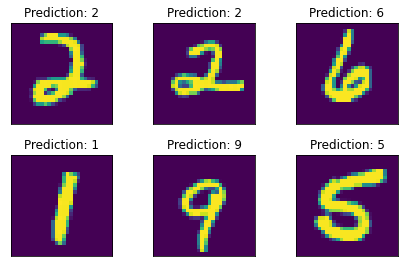

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].cpu(), cmap='viridis', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig


/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:79: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.355794
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.741334
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.947001
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.839711
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.599326
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.778056
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.592119
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.322864
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.587028
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.192830
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.326503
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.337440
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.227561
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.141280
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.412128
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.360067
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.216566
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.241097
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.313894
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.155253
Train Epoch: 1 [12800/60000 (

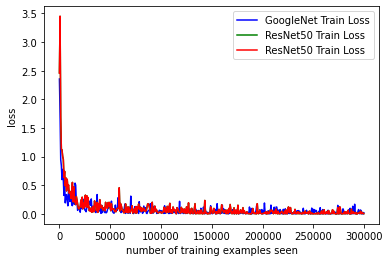

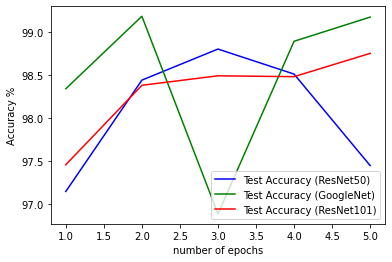

In [ ]:
"""### GoogleNet"""

model2 = googlenet(num_classes=10)
model2.conv1.conv = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model2=model2.cuda()

optimizer = optim.SGD(model2.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses2 = []
train_counter2 = []
test_losses2 = []
test_counter2 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc2 = []

"""Training function"""

def trainGN(epoch):
  model2.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data=data.cuda()
    target=target.cuda()
    output = model2(data)
    loss = criterion(output.logits, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses2.append(loss.item())
      train_counter2.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model2.state_dict(), '/googlenetmodel.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

"""Testing function"""

def testGN():
  model2.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data=data.cuda()
      target=target.cuda()
      output = model2(data)
      test_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses2.append(test_loss)
  test_acc = 100 * correct / len(test_loader.dataset)
  test_acc2.append(test_acc)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

"""Visualizing loss and accuracy at each epoch"""

epochs=[]
for epoch in range(1, n_epochs + 1):
  trainGN(epoch)
  testGN()
  epochs.append(epoch)

"""Plotting training loss"""

fig = plt.figure()
plt.plot(train_counter2, train_losses2, color='blue')
plt.plot(train_counter2, train_losses, color='green')
plt.plot(train_counter3, train_losses, color='red')
plt.legend(['GoogleNet Train Loss','ResNet50 Train Loss','ResNet50 Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')
fig

"""Plotting testing accuracy"""

fig = plt.figure()
plt.plot(epochs, test_acc1, color='blue')
plt.plot(epochs, test_acc2, color='green')
plt.plot(epochs, test_acc3, color='red')
plt.legend(['Test Accuracy (ResNet50)','Test Accuracy (GoogleNet)','Test Accuracy (ResNet101)'], loc='lower right')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy %')
fig

"""Visualizing predicted data"""
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  example_data = example_data.cuda()
  output = model(example_data)

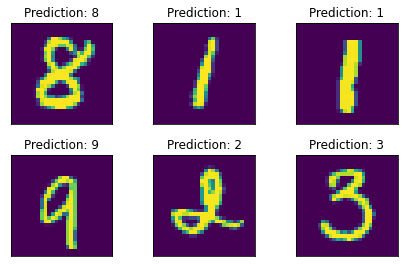

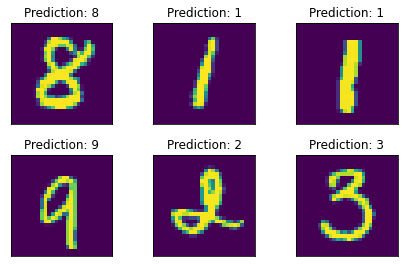

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].cpu(), cmap='viridis', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig